# Chapter 5: Generate Images with GANs





When we generate images by using GANs, we try to learn the true distribution of the images in the training set. Let's denote the true distribution of the data in the training set as $p(x|\theta)$. The generator is trying to learn the parameters $\theta$ to estimate the true data distribution $p(x|\theta)$. Let's call the estimated distribution by the generator $q(x|\theta')$. The generator then draws a sample from $q(x|\theta')$ and presents to the discriminator D to pass as a true sample. After many rounds of back and forth, the generator is able to produce samples that are indistinguishable from real samples while the discriminator assigns a probability of 50% to any sample (real or fake) that it's real. 

Of course, this is the idea behind any GAN model. In this chapter, we'll apply GANs to grayscale images and show that GAN models are very effective in learning the true distribution of the training data and as a result, the trained generator can create images that are very close to the original images from the training data set. We'll apply the model to the Fashion MNIST data set that contains grayscale clothes items such as sandals, t-shirts, trousers. You'll use only fully-connected dense layers in the neural networks. You'll not be using any convolutional layers. We'll cover Deep Convolutional GANs in the next chapter when we deal with high resolution color images. 

Start a new cell in ch05.ipynb and execute the following lines of code in it:

In [1]:
import os

os.makedirs("files/ch05", exist_ok=True)

# 1.  A GAN to Generate Clothes Items
Our goal is to train a model to generate gray-scale images of clothes items such as sandals, t-shirts, coats, and bags. We first download the training data, and arrange them in batches for training later. 

## 1.1. Download the Training Data
You can download the Fashion MNIST data directly from Torchvision datasets, as you did in Chapter 2. 

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

transform=T.Compose([
    T.ToTensor(),
    T.Normalize([0.5],[0.5])])

The *transforms* package in Torchvision can help create a series of transformations to preprocess images. The *ToTensor()* class converts image data (in either PIL image formats or NumPy arrays) into PyTorch tensors. In particular, the image data are integers ranging from 0 to 255 and the *ToTensor()* class converts them to float tensors with values in the range of 0.0 and 1.0. 

The *Normalize()* class normalizes tensor images with mean and standard deviation for *n* channels. The Fashion MNIST data are grayscale images of clothes items so there is only one color channel. Later in this book you'll deal with images of three different color channels (RGB, meaning red, green, and blue). In the code cell above, *Normalize([0.5],[0.5])* means that we subtract 0.5 from the data and divide the difference by 0.5. The resulting image data ranges from -1 to 1. 

Next, we use the *datasets* package in Torchvision to download the dataset to a folder on your computer and perform the transformation, like so:

In [3]:
train_set=torchvision.datasets.FashionMNIST(root=r"C:\temp",
    train=True,download=True,transform=transform) 

Next, we'll create batches of data for training. 

There are 60,000 images in the training set. Next, we create batches to prepare for training the deep neural networks in GAN later:

In [4]:
batch_size=32
train_loader=torch.utils.data.DataLoader(
    train_set,batch_size=batch_size,shuffle=True)

The DataLoader class in the PyTorch *utils* package helps create data iterators in batches. We set the batch size to 32. Next, we use the *make_grid()* method in Torchvision to convert a batch of 32 images into one image and plot them, as follows: 

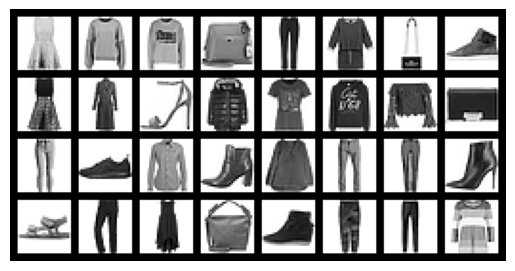

In [5]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

images, labels = next(iter(train_loader))
# Plot all the images of the 1st batch in grid
grid = make_grid(0.5-images/2, 8, 4)
plt.imshow(grid.numpy().transpose((1, 2, 0)),
          cmap="gray_r")
plt.axis("off")
plt.show()

Here I use *0.5-images/2* to convert white clothes items with black backgrounds to black clothe items with white backgrounds. When the image pixels are normalized to the range -1 and 1.0, we usually use *images/2+0.5* to convert image pixels to the range 0.0 and 1.0 (white is 1.0 and black is 0.0). By using *0.5-images/2*, we set white as 0.0 and black as 1.0. 

## 1.2. The Discriminator D
The discriminator D is a binary classifier, which is very similar to the binary classifier for clothes items we discussed in Chapter 2. Here the discriminator's job is to classify the samples into either real or fake. 

We use PyTorch to create the following discriminator neural network D, like so:

In [6]:
import torch.nn as nn

# determine the device automatically
device="cuda" if torch.cuda.is_available() else "cpu"
# the discriminator D is a binary classifier
D=nn.Sequential(
    nn.Linear(784, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 1),
    nn.Sigmoid()).to(device)

The input size is 784 because the image is 28 by 28. We flatten the images to one-dimensional tensors and feed them to the model. The output layer has just one neuron in it: the output of the discriminator D is a single value. We use the Sigmoid activation function to squeeze the output to the range [0, 1] so it can be interpreted as the probability that the sample is real. With complementary probability 1-p, the sample is fake. 

## 1.3. The Generator G
The generator G's job is to create a piece of clothes item so that it can pass as real in front of the discriminator D. That is, G is trying to create a clothes item to maximize the probability that D thinks it is from the training dataset.

We create the following neural network to represent the generator G:

In [7]:
G=nn.Sequential(
    nn.Linear(100, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 784),
    nn.Tanh()).to(device)

We'll feed random data from a 100-dimensional latent space, $(z_1, z_2, ..., z_{100})$, to the generator. We use the tanh activation function in the last layer so the output is between -1 and 1, and this matches the values in the normalized image pixel values. 

## 1.4. Optimizers and the Loss Function

The loss function is binary cross-entropy loss. The discriminator D is trying to maximize the accuracy of the binary classification: identify a real sample as real and a fake sample as fake. The generator, on the other hand, is trying to minimize the probability that the fake sample is being identified as fake. 

We'll use the Adam optimizer for both the discriminator and the generator:

In [8]:
loss_fn=nn.BCELoss()
lr=0.0001
optimD=torch.optim.Adam(D.parameters(),lr=lr)
optimG=torch.optim.Adam(G.parameters(),lr=lr)

# 2. Train the Image GAN
Now that we have the training data and two networks, we'll train the model. After that, we'll discard the discriminator and use the generator to generate clothes items.

## 2.1. Test Ouput Periodically
We'll crate a function to test what the fake images generated by G look like. 

In [9]:
import matplotlib.pyplot as plt

def test():
    noise=torch.randn(batch_size,100).to(device=device)
    fake_samples=G(noise).cpu().detach()
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow((fake_samples[i]/2+0.5).reshape(28, 28))
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(hspace=-0.6)
    plt.show()    

Before training, the fake samples look as follows:

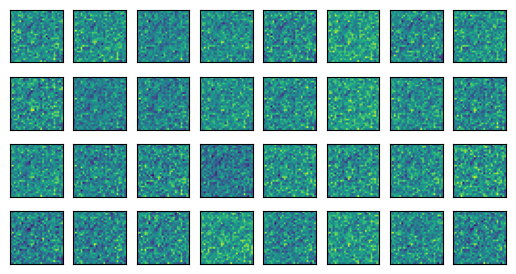

In [10]:
test()

As you can see, before training, the fake images look not at all like clothes items. 

## 2.2. Train the Model
We first create labels of zeros and ones as follows:

In [11]:
real_labels=torch.ones((batch_size,1)).to(device)
fake_labels=torch.zeros((batch_size,1)).to(device)

The real labels are all ones, while the fake labels are all zeros. We'll compare these labels with the predictions from the discriminator to train both the discriminator and the generator. 

We train the model for 50 epochs, as follows:

at epoch 10, dloss: 1.0581433773040771, gloss 0.9249964952468872


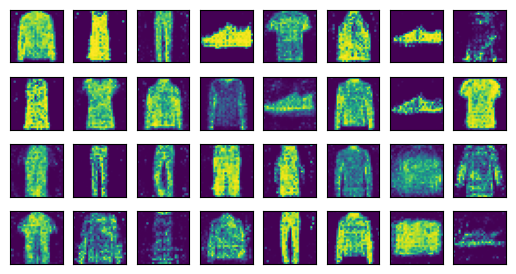

at epoch 20, dloss: 1.19633948802948, gloss 0.8954355716705322


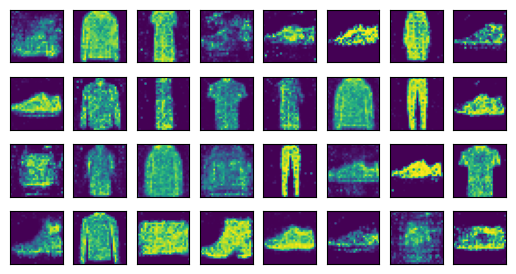

at epoch 30, dloss: 1.2286581993103027, gloss 0.9420900940895081


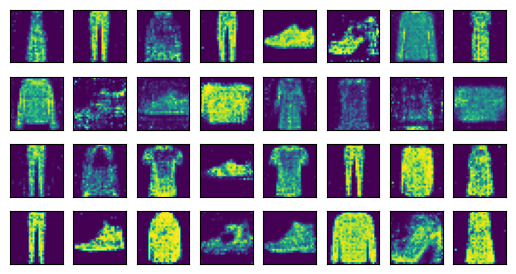

at epoch 40, dloss: 1.1491079330444336, gloss 0.8973125219345093


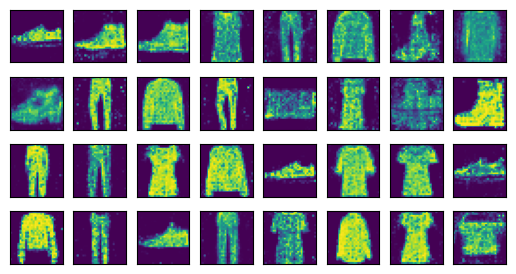

at epoch 50, dloss: 1.2713582515716553, gloss 0.864443302154541


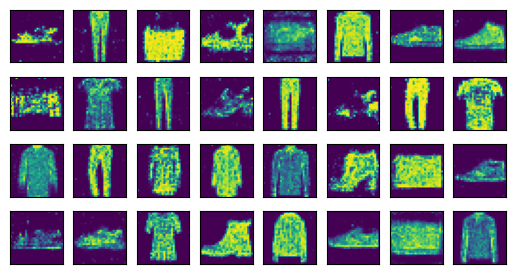

In [12]:
for i in range(50):
    for n, (real_samples,_) in enumerate(train_loader):    
        gloss=dloss=0
        # train discriminator on real data
        real_samples=real_samples.reshape(-1,28*28).to(device)
        preds=D(real_samples)
        labels=torch.ones((real_samples.shape[0],1)).to(device)
        loss_D=loss_fn(preds,labels)
        optimD.zero_grad()
        loss_D.backward()
        optimD.step()
        dloss+=loss_D    
        # train D on fake data
        noise=torch.randn(batch_size,100).to(device=device)
        generated_data=G(noise)
        # use 0 as labels since they are fake
        preds=D(generated_data)
        loss_D=loss_fn(preds,fake_labels)
        optimD.zero_grad()
        loss_D.backward()
        optimD.step()
        dloss+=loss_D      
        # train G 
        noise=torch.randn(batch_size,100).to(device=device)
        generated_data=G(noise)
        # use 1 as labels since G wants to fool D
        preds=D(generated_data)
        loss_G=loss_fn(preds,real_labels)
        optimG.zero_grad()
        loss_G.backward()
        optimG.step()
        gloss+=loss_G      
    if i % 10 == 9:
        print(f"at epoch {i+1}, dloss: {dloss}, gloss {gloss}")
        test()

In each iteration, we generate a batch of 32 clothes items. We first train the discriminator using the real samples. After that, the generator creates a batch of fake samples and we use them to train the discriminator D again. Finally, we let the generator create a batch of fake samples again, but we use them to train the generator instead.

After just ten epochs of training, the model can already generate clothes items that are clearly can pass as real: you can clearly tell what they are. The first three items in the first row are clearly a coat, a dress, and a pair of trousers. 

## 2.3. Save and Use the Generator
We'll discard the discriminator and save the trained generator on the local folder, as follows:

In [13]:
# Export to TorchScript
scripted = torch.jit.script(G) 
# Save the model
import os
os.makedirs("files/ch05", exist_ok=True)
scripted.save('files/ch05/fashion_gen.pt') 

We have now saved the generator in the local folder. To use the generator, we don't even need to define the model. We simply load up the model and use it to generate data points as follows: 

In [14]:
new_G=torch.jit.load('files/ch05/fashion_gen.pt',
                     map_location=device)
new_G.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
  (2): RecursiveScriptModule(original_name=Linear)
  (3): RecursiveScriptModule(original_name=ReLU)
  (4): RecursiveScriptModule(original_name=Linear)
  (5): RecursiveScriptModule(original_name=ReLU)
  (6): RecursiveScriptModule(original_name=Linear)
  (7): RecursiveScriptModule(original_name=Tanh)
)

The generator is now reloaded. We can use it to generate clothes items as follows:

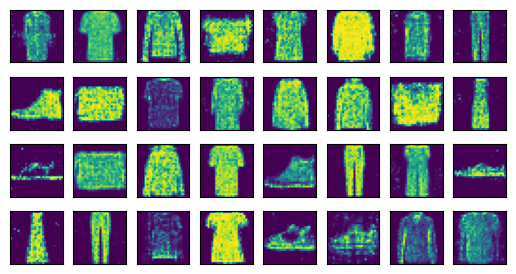

In [15]:
noise=torch.randn(batch_size,100).to(device=device)
fake_samples=new_G(noise).cpu().detach()
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow((fake_samples[i]/2+0.5).reshape(28, 28))
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(hspace=-0.6)
plt.show() 

The generated clothes items are close to the ones in the original dataset.